# Fisher Linear Discriminant Analysis
Learning Task 1: Build Fisher’s linear discriminant model (FLDM1) on the training data and thus 
reduce  32  dimensional  problem  to  univariate  dimensional  problem.  Find  out  the  decision 
boundary  in  the  univariate  dimension  using  generative  approach.  You  may  assume  gaussian 
distribution for both positive and negative classes in the univariate dimension.  

Learning Task 2: Change the  order  of features in the  dataset  randomly. Equivalently speaking, 
for an example of feature tuple (f1, f2, f3, f4, . . , f32), consider a random permutation (f3, f1, f4, 
f2, f6, ....., f32) and build the Fisher’s linear discriminant model (FLDM2)  on  the  same  training 
data as in the learning task 1. Find out the decision boundary in the univariate dimension using 
generative approach and you may assume gaussian distribution  for both positive and negative 
classes  in  the  univariate  dimension.  Outline  the  difference  between  the  models  –  FLDM1  and 
FLDM2 - and their respective performances

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils_ml import generate_confusion_matrix

## Importing the dataset

In [2]:
# Read the csv file
dataset = pd.read_csv('../dataset.csv')
print(dataset.shape)

(569, 32)


In [3]:
# Convert cancer type into a new column
dataset["cancer_type"] = pd.factorize(dataset["diagnosis"])[0]
dataset.head()

# Malignant is 0 and Benign is 1

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,cancer_type
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
# Remove ID and diagnosis from the dataset
dataset.drop(['id', 'diagnosis'], axis=1, inplace=True)

# Drop NA rows because in first one we shouldn't use NA
dropped_dataset = dataset.dropna()

print(dropped_dataset[dropped_dataset.isna().any(axis=1)])
print(dropped_dataset.head())

Empty DataFrame
Columns: [radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst, cancer_type]
Index: []

[0 rows x 31 columns]
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0        

# Fisher Linear Discriminant Analysis Class

In [31]:
class FisherLDA:
    def __init__(self, dataset: pd.DataFrame, is_feature_engineered = 0):
        # Initializing the dataset
        self.dataset = dataset
        
        # Filling with mean
        if is_feature_engineered == 1:
            self.dataset = self.dataset.fillna(dataset.mean(numeric_only=True))

        self.training_dataset = self.dataset.iloc[:int(
            0.67*self.dataset.shape[0]), :]

        self.testing_dataset = self.dataset.iloc[int(
            0.67*self.dataset.shape[0]):, :]
        
        # Normalization
        if is_feature_engineered == 1:
            mean = self.training_dataset.iloc[:, :-1].mean(numeric_only=True)
            std = self.training_dataset.iloc[:, :-1].std()
            self.training_dataset.iloc[:, :-1] = (self.training_dataset.iloc[:, :-1] - mean)/std
            self.testing_dataset.iloc[:, :-1] = (self.testing_dataset.iloc[:, :-1] - mean)/std 

        # Training Dataset
        # Splitting the dataset category wise for the training data
        # This is done in fisher, because we need separate data
        # 1 is benign and 0 is malignant
        self.training_dataset_benign = self.training_dataset[
            self.training_dataset["cancer_type"] == 1]
        self.training_dataset_malign = self.training_dataset[
            self.training_dataset["cancer_type"] == 0]

        # Convert these into values
        self.X_train_values_benign = self.training_dataset_benign.iloc[:, :-1].values
        self.X_train_values_malign = self.training_dataset_malign.iloc[:, :-1].values

        print(f"Shape of Benign Training Data (incl. output column): {self.training_dataset_benign.shape}")
        print(f"Shape of Malignant Training Data (incl. output column): {self.training_dataset_malign.shape}")

        # Datasets for accuracy
        self.X_train = self.training_dataset.iloc[:, :-1].values
        self.y_train = self.training_dataset.iloc[:, -1].values
        self.X_test = self.testing_dataset.iloc[:, :-1].values
        self.y_test = self.testing_dataset.iloc[:, -1].values

        # Make an initial array of w
        self.w = np.zeros(self.dataset.shape[1] - 1)

        # For the final answer, we need to P(malign | w,x) = P(w,x | malign)P(malign)
        # We take P(w, x | malign) as a normal distribution
        self.probability_malign = self.training_dataset_malign.shape[0] / (
            self.training_dataset_benign.shape[0] + self.training_dataset_malign.shape[0])
        self.probability_benign = self.training_dataset_benign.shape[0] / (
            self.training_dataset_benign.shape[0] + self.training_dataset_malign.shape[0])
        
        self.covariance_matrix_s1 = np.zeros(
            (self.X_train_values_benign.shape[1],
             self.X_train_values_benign.shape[1])
        )
        self.covariance_matrix_s2 = np.zeros(
            (self.X_train_values_malign.shape[1],
             self.X_train_values_malign.shape[1])
        )


    def train(self):
        # Using notebook notations:
        # Category 1: Benign
        # Category 2: Malignant

        # m1bar = mean of features for category 1
        # m2bar = mean of features for category 2
        m1bar = self.X_train_values_benign.mean(axis=0)
        m2bar = self.X_train_values_malign.mean(axis=0)
        
        # print(m1bar)
        # print(m2bar)

        covariance_matrix_s1 = np.zeros(
            (self.X_train_values_benign.shape[1],
             self.X_train_values_benign.shape[1])
        )
        covariance_matrix_s2 = np.zeros(
            (self.X_train_values_malign.shape[1],
             self.X_train_values_malign.shape[1])
        )

        # s1_component is giving us Sigma(x_n - m1bar)(x_n - m1bar)T
        for index, x in enumerate(self.X_train_values_benign):
            col_matrix = (x - m1bar).reshape((x - m1bar).shape[0], 1)
            row_matrix = col_matrix.T

            # Just a note for future: np.transpose does not work on 1D array, since it counts as 0D vector
            # col_matrix = np.transpose(x - m1bar)
            # print(col_matrix.shape)

            covariance_matrix_s1 += (col_matrix * row_matrix)

        # s2_component is giving us Sigma(x_n - m2bar)(x_n - m2bar)T
        for index, x in enumerate(self.X_train_values_malign):
            col_matrix = (x - m2bar).reshape((x - m2bar).shape[0], 1)
            row_matrix = col_matrix.T

            # Just a note for future: np.transpose does not work on 1D array, since it counts as 0D vector
            # col_matrix = np.transpose(x - m1bar)
            # print(col_matrix.shape)

            covariance_matrix_s2 += (col_matrix * row_matrix)

        s_w = (covariance_matrix_s1) + (covariance_matrix_s2)
        s_w_inv = np.linalg.inv(s_w)

        self.w = np.matmul(
            s_w_inv, (m2bar - m1bar).reshape((m2bar - m2bar).shape[0], 1))

        return self.w

    def predict(self, x_input):
        # List of all the projected points
        x_malign = [np.matmul(self.w.T,x)[0] for x in self.X_train_values_malign]
        x_benign = [np.matmul(self.w.T,x)[0] for x in self.X_train_values_benign]
        
        # Here each set of 3 lines calculates
        # 1/(2pi*sigma)^0.5 * e^(-(1/2*sigma)(x-mu)^2)
        # This is just giving us P(w_tx)
        scalar_s1 = (1. / ((2 * np.pi) ** (1 / 2.))) * (1 / ((np.std(x_benign))))
        x_sub_u_s1 = np.subtract(np.matmul(self.w.T,x_input.reshape(x_input.shape[0], 1)), np.mean(x_benign))
        p_s1 = scalar_s1 * np.exp(-np.dot(x_sub_u_s1, x_sub_u_s1.T) / (np.std(x_benign) * np.std(x_benign) * 2.))
        
        scalar_s2 = (1. / ((2 * np.pi) ** (1 / 2.))) * (1 / (np.std(x_malign)))
        x_sub_u_s2 = np.subtract(np.matmul(self.w.T,x_input.reshape(x_input.shape[0], 1)), np.mean(x_malign))
        p_s2 = scalar_s2 * np.exp(-np.dot(x_sub_u_s2, x_sub_u_s2.T) / (np.std(x_malign) * np.std(x_malign) * 2.))        
        
        # print(f"Benign: {str(p_s1[0][0]).ljust(30)} Malignant: {str(p_s2[0][0]).ljust(30)}")
        probs =  [p_s1 * self.probability_benign, p_s2 * self.probability_malign]
        
        # While returning 0 returns the probabilities while 1 returns the prediction
        return [probs, 1 if probs[0] > probs[1] else 0]
    
    def check_training_accuracy(self):
        y_predicted = [self.predict(x)[1] for x in self.X_train]
        print(f"Training Predicted: {y_predicted}")
        return generate_confusion_matrix(y_pred=np.array(y_predicted), y_true=self.y_train)[0]
    
    def check_testing_accuracy(self):
        y_predicted = [self.predict(x)[1] for x in self.X_test]
        self.y_test_predicted = y_predicted
        print(f"Testing Predicted: {y_predicted}")
        return generate_confusion_matrix(y_pred=np.array(y_predicted), y_true=self.y_test)[0]
    
    # Required seaborn
    # def plot_training_data(self):
    #     benign = [self.predict(x)[0][0][0][0] for x in self.X_train_values_benign]
    #     malign = [self.predict(x)[0][1][0][0] for x in self.X_train_values_malign]
    #     sns.kdeplot(benign, density=True)
    #     sns.kdeplot(malign, density=True)
        
    def get_normal_distribution(self, x_input, mean, stan_dev):
        return 1/(np.sqrt(2*np.pi*stan_dev*stan_dev)) * np.exp(-(x_input-mean)**2/(2*stan_dev*stan_dev))
        
    def plot_normal_distribution(self):
        x_malign = [np.matmul(self.w.T,x)[0] for x in self.X_train_values_malign]
        x_benign = [np.matmul(self.w.T,x)[0] for x in self.X_train_values_benign]
  
        # Calculating mean and standard deviation
        mean_malign = np.mean(x_malign)
        sd_malign = np.std(x_malign)
        mean_benign = np.mean(x_benign)
        sd_benign = np.std(x_benign)
        
        # Generate 1000 samples from the normal distribution
        samples_malign = np.random.normal(mean_malign, sd_malign, 1000)
        samples_benign = np.random.normal(mean_benign, sd_benign, 1000)

        # Plot a histogram of the samples_malign
        # Plot histograms of the data with overlaid PDFs
        plt.hist(samples_malign, bins=50, density=True, alpha=0.5, color='blue', label='Malignant')
        plt.hist(samples_benign, bins=50, density=True, alpha=0.5, color='green', label='Benign')

        # Create an array of random values
        x = np.linspace(-0.5, 0.5, 1000)
        
        # Calculate prob_dist_funcs for each class and plot them
        prob_dist_func_m = self.get_normal_distribution(x, mean_malign, sd_malign)
        prob_dist_func_b = self.get_normal_distribution(x, mean_benign, sd_benign)
        plt.plot(x, prob_dist_func_m, color='blue', label='Malignant prob_dist_func')
        plt.plot(x, prob_dist_func_b, color='green', label='Benign prob_dist_func')

        # Set the title and labels
        plt.title('Normal Distribution of malign and benign')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        
        # Find intersection point of the prob_dist_funcs and plot it
        intersection = np.argwhere(np.diff(np.sign(prob_dist_func_m - prob_dist_func_b))).flatten()
        plt.plot(x[intersection], prob_dist_func_m[intersection], 'ro', markersize=10)

        # Add legend and axis labels
        plt.legend()
        plt.xlabel('LDA Component')
        plt.ylabel('Density')

        # Show the plot
        plt.show()
    
    def show_confusion_matrix(self):
        cm = generate_confusion_matrix(y_true=(self.y_test), y_pred=np.array(self.y_test_predicted))

        accuracy = cm[0]
        precision = cm[1]
        recall = cm[2]
        f1 = cm[3]
        
        return accuracy, precision, f1, recall

# FLDM1

In [32]:
fldm1 = FisherLDA(dataset=dropped_dataset)

Shape of Benign Training Data (incl. output column): (209, 31)
Shape of Malignant Training Data (incl. output column): (168, 31)


In [33]:
w = fldm1.train()

In [34]:
fldm1.y_test

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [35]:
fldm1.check_training_accuracy()

Training Predicted: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1

0.9761273209549072

In [36]:
fldm1.check_testing_accuracy()

Testing Predicted: [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]


0.9731182795698925

In [37]:
fldm1.show_confusion_matrix()

(0.9731182795698925, 0.9928571428571429, 0.9823321554770317, 0.972027972027972)

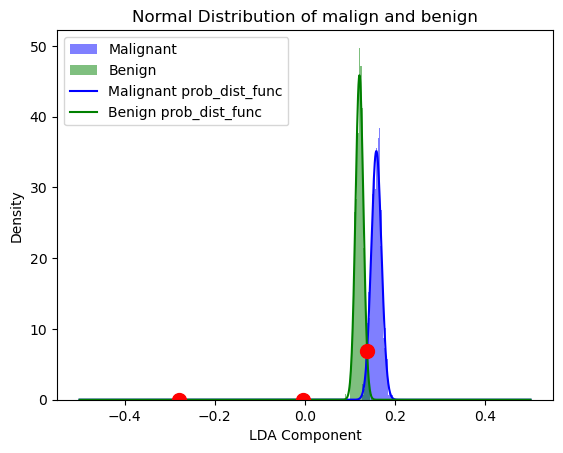

In [38]:
fldm1.plot_normal_distribution()


# FLDM1 with Normalized Dataset

In [39]:
fldm1_normalized = FisherLDA(dataset=dataset, is_feature_engineered=1)

Shape of Benign Training Data (incl. output column): (212, 31)
Shape of Malignant Training Data (incl. output column): (169, 31)


C:\Users\divya\AppData\Local\Temp\ipykernel_14996\3350081143.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.training_dataset.iloc[:, :-1] = (self.training_dataset.iloc[:, :-1] - mean)/std
C:\Users\divya\AppData\Local\Temp\ipykernel_14996\3350081143.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.testing_dataset.iloc[:, :-1] = (self.testing_dataset.iloc[:, :-1] - mean)/std


In [40]:
w_normalized = fldm1_normalized.train()

In [41]:
fldm1_normalized.y_test

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [42]:
fldm1_normalized.check_training_accuracy()

Training Predicted: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1

0.9763779527559056

In [43]:
fldm1_normalized.check_testing_accuracy()

Testing Predicted: [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]


0.9680851063829787

In [45]:
fldm1_normalized.show_confusion_matrix()

(0.9680851063829787,
 0.9929078014184397,
 0.9790209790209791,
 0.9655172413793104)

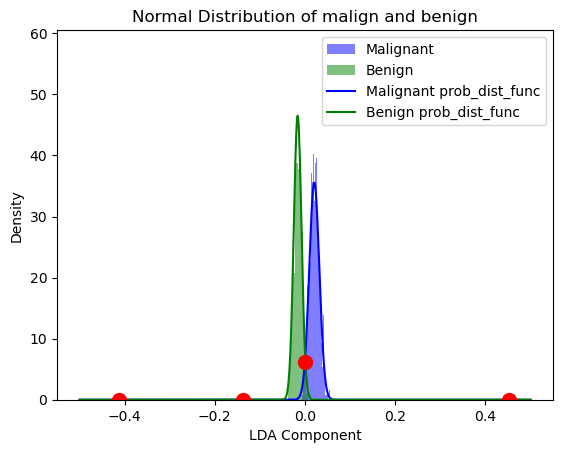

In [46]:
fldm1_normalized.plot_normal_distribution()

# FLDM2

In [47]:
dataset = pd.read_csv('../dataset.csv')
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [48]:
# Shuffling the dataset column wise
dataset_column_shuffled = dataset.sample(frac=1, axis=1)
dataset_column_shuffled.head()

,texture_mean,area_worst,concave points_worst,concavity_mean,perimeter_mean,radius_se,perimeter_se,texture_worst,smoothness_se,diagnosis,...,concave points_mean,fractal_dimension_mean,texture_se,symmetry_se,radius_worst,area_se,radius_mean,symmetry_mean,smoothness_worst,compactness_worst
0,10.38,2019.0,0.2654,0.3001,122.80,1.0950,8.589,17.33,0.006399,M,...,0.14710,0.07871,0.9053,0.03003,25.38,153.40,17.99,0.2419,0.1622,0.6656
1,17.77,1956.0,0.1860,0.0869,132.90,0.5435,3.398,23.41,0.005225,M,...,0.07017,0.05667,0.7339,0.01389,24.99,74.08,20.57,0.1812,0.1238,0.1866
2,21.25,1709.0,0.2430,0.1974,130.00,0.7456,4.585,25.53,0.006150,M,...,0.12790,0.05999,0.7869,0.02250,23.57,94.03,19.69,0.2069,0.1444,0.4245
3,20.38,567.7,0.2575,0.2414,77.58,0.4956,3.445,26.50,0.009110,M,...,0.10520,0.09744,1.1560,0.05963,14.91,27.23,11.42,0.2597,0.2098,0.8663
4,14.34,1575.0,0.1625,0.1980,135.10,0.7572,5.438,16.67,0.011490,M,...,0.10430,0.05883,0.7813,0.01756,22.54,94.44,20.29,0.1809,0.1374,0.2050


In [49]:
# Convert cancer type into a new column
dataset_column_shuffled["cancer_type"] = pd.factorize(dataset_column_shuffled["diagnosis"])[0]
dataset_column_shuffled.head()

# Malignant is 0 and Benign is 1

,texture_mean,area_worst,concave points_worst,concavity_mean,perimeter_mean,radius_se,perimeter_se,texture_worst,smoothness_se,diagnosis,...,fractal_dimension_mean,texture_se,symmetry_se,radius_worst,area_se,radius_mean,symmetry_mean,smoothness_worst,compactness_worst,cancer_type
0,10.38,2019.0,0.2654,0.3001,122.80,1.0950,8.589,17.33,0.006399,M,...,0.07871,0.9053,0.03003,25.38,153.40,17.99,0.2419,0.1622,0.6656,0
1,17.77,1956.0,0.1860,0.0869,132.90,0.5435,3.398,23.41,0.005225,M,...,0.05667,0.7339,0.01389,24.99,74.08,20.57,0.1812,0.1238,0.1866,0
2,21.25,1709.0,0.2430,0.1974,130.00,0.7456,4.585,25.53,0.006150,M,...,0.05999,0.7869,0.02250,23.57,94.03,19.69,0.2069,0.1444,0.4245,0
3,20.38,567.7,0.2575,0.2414,77.58,0.4956,3.445,26.50,0.009110,M,...,0.09744,1.1560,0.05963,14.91,27.23,11.42,0.2597,0.2098,0.8663,0
4,14.34,1575.0,0.1625,0.1980,135.10,0.7572,5.438,16.67,0.011490,M,...,0.05883,0.7813,0.01756,22.54,94.44,20.29,0.1809,0.1374,0.2050,0


In [50]:
# Remove ID and diagnosis from the dataset
dataset_column_shuffled.drop(['id', 'diagnosis'], axis=1, inplace=True)

In [51]:
# Drop NA rows because in first one we shouldn't use NA
dropped_dataset_column_shuffled = dataset_column_shuffled.dropna()

print(dropped_dataset_column_shuffled[dropped_dataset_column_shuffled.isna().any(axis=1)])
dropped_dataset_column_shuffled.head()
# feature_engineered_dataset_column_shuffled.head()

Empty DataFrame
Columns: [texture_mean, area_worst, concave points_worst, concavity_mean, perimeter_mean, radius_se, perimeter_se, texture_worst, smoothness_se, area_mean, symmetry_worst, perimeter_worst, compactness_se, smoothness_mean, fractal_dimension_worst, concave points_se, concavity_se, compactness_mean, concavity_worst, fractal_dimension_se, concave points_mean, fractal_dimension_mean, texture_se, symmetry_se, radius_worst, area_se, radius_mean, symmetry_mean, smoothness_worst, compactness_worst, cancer_type]
Index: []

[0 rows x 31 columns]


,texture_mean,area_worst,concave points_worst,concavity_mean,perimeter_mean,radius_se,perimeter_se,texture_worst,smoothness_se,area_mean,...,fractal_dimension_mean,texture_se,symmetry_se,radius_worst,area_se,radius_mean,symmetry_mean,smoothness_worst,compactness_worst,cancer_type
0,10.38,2019.0,0.2654,0.3001,122.80,1.0950,8.589,17.33,0.006399,1001.0,...,0.07871,0.9053,0.03003,25.38,153.40,17.99,0.2419,0.1622,0.6656,0
1,17.77,1956.0,0.1860,0.0869,132.90,0.5435,3.398,23.41,0.005225,1326.0,...,0.05667,0.7339,0.01389,24.99,74.08,20.57,0.1812,0.1238,0.1866,0
2,21.25,1709.0,0.2430,0.1974,130.00,0.7456,4.585,25.53,0.006150,1203.0,...,0.05999,0.7869,0.02250,23.57,94.03,19.69,0.2069,0.1444,0.4245,0
3,20.38,567.7,0.2575,0.2414,77.58,0.4956,3.445,26.50,0.009110,386.1,...,0.09744,1.1560,0.05963,14.91,27.23,11.42,0.2597,0.2098,0.8663,0
4,14.34,1575.0,0.1625,0.1980,135.10,0.7572,5.438,16.67,0.011490,1297.0,...,0.05883,0.7813,0.01756,22.54,94.44,20.29,0.1809,0.1374,0.2050,0


In [52]:
fldm2 = FisherLDA(dataset=dropped_dataset_column_shuffled)

Shape of Benign Training Data (incl. output column): (209, 31)
Shape of Malignant Training Data (incl. output column): (168, 31)


In [53]:
w = fldm2.train()

In [54]:
fldm2.y_test

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [55]:
fldm2.check_training_accuracy()

Training Predicted: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1

0.9761273209549072

In [56]:
fldm2.check_testing_accuracy()

Testing Predicted: [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]


0.9731182795698925

In [57]:
fldm2.show_confusion_matrix()


(0.9731182795698925, 0.9928571428571429, 0.9823321554770317, 0.972027972027972)

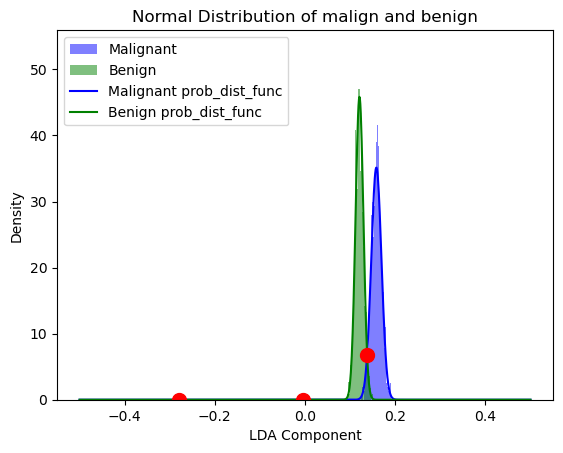

In [58]:
fldm2.plot_normal_distribution()

# FLDM2 with Normalized Dataset

In [59]:
fldm2_normalized = FisherLDA(dataset=dataset_column_shuffled, is_feature_engineered=1)

Shape of Benign Training Data (incl. output column): (212, 31)
Shape of Malignant Training Data (incl. output column): (169, 31)


C:\Users\divya\AppData\Local\Temp\ipykernel_14996\3350081143.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.training_dataset.iloc[:, :-1] = (self.training_dataset.iloc[:, :-1] - mean)/std
C:\Users\divya\AppData\Local\Temp\ipykernel_14996\3350081143.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.testing_dataset.iloc[:, :-1] = (self.testing_dataset.iloc[:, :-1] - mean)/std


In [60]:
w2_normalized = fldm2_normalized.train()

In [61]:
fldm2_normalized.y_test

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [62]:
fldm2_normalized.check_training_accuracy()

Training Predicted: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1

0.9763779527559056

In [63]:
fldm2_normalized.check_testing_accuracy()

Testing Predicted: [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]


0.9680851063829787

In [65]:
fldm2_normalized.show_confusion_matrix()

(0.9680851063829787,
 0.9929078014184397,
 0.9790209790209791,
 0.9655172413793104)

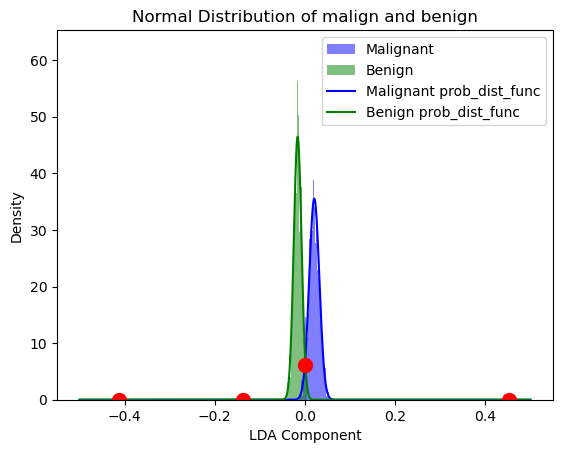

In [66]:
fldm2_normalized.plot_normal_distribution()

# Looping for 10 times and dying

In [67]:
%%capture
fldm1_details = {
    "training_accuracy": 0,
    "accuracy_avg": 0,
    "precision_avg": 0,
    "f1_avg": 0,
    "recall_avg": 0
}
fldm1_normalized_details = {
    "training_accuracy": 0,
    "accuracy_avg": 0,
    "precision_avg": 0,
    "f1_avg": 0,
    "recall_avg": 0
}
fldm2_details = {
    "training_accuracy": 0,
    "accuracy_avg": 0,
    "precision_avg": 0,
    "f1_avg": 0,
    "recall_avg": 0
}
fldm2_normalized_details = {
    "training_accuracy": 0,
    "accuracy_avg": 0,
    "precision_avg": 0,
    "f1_avg": 0,
    "recall_avg": 0
}

for _ in range(10):
    # Read the csv file
    dataset = pd.read_csv('../dataset.csv')
    dataset = dataset.sample(frac=1)

    # Shuffling the dataset column wise
    dataset_column_shuffled = dataset.sample(frac=1, axis=1)
    # Convert cancer type into a new column
    dataset_column_shuffled["cancer_type"] = pd.factorize(
        dataset_column_shuffled["diagnosis"])[0]
    # Malignant is 0 and Benign is 1
    # Remove ID and diagnosis from the dataset
    dataset_column_shuffled.drop(['id', 'diagnosis'], axis=1, inplace=True)
    
    # Drop NA rows because in first one we shouldn't use NA
    dropped_dataset_column_shuffled = dataset_column_shuffled.dropna()

    # Convert cancer type into a new column
    dataset["cancer_type"] = pd.factorize(dataset["diagnosis"])[0]
    # Malignant is 0 and Benign is 1
    # Remove ID and diagnosis from the dataset
    dataset.drop(['id', 'diagnosis'], axis=1, inplace=True)
    
    # Drop NA rows because in first one we shouldn't use NA
    dropped_dataset = dataset.dropna()

    # FLDM1
    fldm1 = FisherLDA(dataset=dropped_dataset)
    fldm1.train()
    fldm1.check_testing_accuracy()
    fldm1_details["training_accuracy"] += fldm1.check_training_accuracy() / 10
    fldm1_details["accuracy_avg"] += fldm1.show_confusion_matrix()[0] / 10
    fldm1_details["precision_avg"] += fldm1.show_confusion_matrix()[1] / 10
    fldm1_details["f1_avg"] += fldm1.show_confusion_matrix()[2] / 10
    fldm1_details["recall_avg"] += fldm1.show_confusion_matrix()[3] / 10

    # FLDM1 with Normalized Dataset
    fldm1_normalized = FisherLDA(dataset=dataset, is_feature_engineered=1)
    fldm1_normalized.train()
    fldm1_normalized.check_testing_accuracy()
    fldm1_normalized_details["training_accuracy"] += fldm1_normalized.check_training_accuracy() / 10
    fldm1_normalized_details["accuracy_avg"] += fldm1_normalized.show_confusion_matrix()[
        0] / 10
    fldm1_normalized_details["precision_avg"] += fldm1_normalized.show_confusion_matrix()[
        1] / 10
    fldm1_normalized_details["f1_avg"] += fldm1_normalized.show_confusion_matrix()[
        2] / 10
    fldm1_normalized_details["recall_avg"] += fldm1_normalized.show_confusion_matrix()[
        3] / 10

    # FLDM2
    fldm2 = FisherLDA(dataset=dropped_dataset_column_shuffled)
    fldm2.train()
    fldm2.check_testing_accuracy()
    fldm2_details["training_accuracy"] += fldm2.check_training_accuracy() / 10
    fldm2_details["accuracy_avg"] += fldm2.show_confusion_matrix()[0] / 10
    fldm2_details["precision_avg"] += fldm2.show_confusion_matrix()[1] / 10
    fldm2_details["f1_avg"] += fldm2.show_confusion_matrix()[2] / 10
    fldm2_details["recall_avg"] += fldm2.show_confusion_matrix()[3] / 10

    # FLDM2 with Normalized Dataset
    fldm2_normalized = FisherLDA(
        dataset=dataset_column_shuffled, is_feature_engineered=1)
    fldm2_normalized.train()
    fldm2_normalized.check_testing_accuracy()
    fldm2_normalized_details["training_accuracy"] += fldm2_normalized.check_training_accuracy() / 10
    fldm2_normalized_details["accuracy_avg"] += fldm2_normalized.show_confusion_matrix()[
        0] / 10
    fldm2_normalized_details["precision_avg"] += fldm2_normalized.show_confusion_matrix()[
        1] / 10
    fldm2_normalized_details["f1_avg"] += fldm2_normalized.show_confusion_matrix()[
        2] / 10
    fldm2_normalized_details["recall_avg"] += fldm2_normalized.show_confusion_matrix()[
        3] / 10

In [68]:
print(f"{fldm1_details=}")
print(f"{fldm1_normalized_details=}")
print(f"{fldm2_details=}")
print(f"{fldm2_normalized_details=}")

fldm1_details={'training_accuracy': 0.976392572944297, 'accuracy_avg': 0.9634408602150537, 'precision_avg': 0.964993333025935, 'f1_avg': 0.9567048236269872, 'recall_avg': 0.9500945167458673}
fldm1_normalized_details={'training_accuracy': 0.9761154855643045, 'accuracy_avg': 0.9638297872340426, 'precision_avg': 0.9629827763078569, 'f1_avg': 0.956816903809444, 'recall_avg': 0.952001299586156}
fldm2_details={'training_accuracy': 0.976392572944297, 'accuracy_avg': 0.9634408602150537, 'precision_avg': 0.964993333025935, 'f1_avg': 0.9567048236269872, 'recall_avg': 0.9500945167458673}
fldm2_normalized_details={'training_accuracy': 0.9761154855643045, 'accuracy_avg': 0.9638297872340426, 'precision_avg': 0.9629827763078569, 'f1_avg': 0.956816903809444, 'recall_avg': 0.952001299586156}
